# Main examples
Here we show how to use the Sij functions for the case of arbitrary redshift kernels. \
This was used for instance in Gouyou Beauchamps et al. 2022 (arXiv:2109.02308) for the full sky case.

### Import modules

In [18]:
import math ; pi=math.pi
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import time

In [19]:
# Import PySSC module
import PySSC

## Compute the S matrix with arbitrary kernels

### Define Gaussian kernels

In [20]:
# Define redshift range
nz    = 500
z_arr = np.linspace(0,2,num=nz+1)[1:] # Redshifts must be > 0
zmin  = z_arr.min() ; zmax = z_arr.max()

In [21]:
sigmaz    = 0.05
zcenter_G = [0.4,0.55,0.7,0.85,1.,1.15,1.3,1.45,1.6]
nbins_G   = len(zcenter_G)
kernels_G = np.zeros((nbins_G,nz))
for i in range(nbins_G):
    kernels_G[i,:] = np.exp(-(z_arr-zcenter_G[i])**2/(2*sigmaz**2)) / np.sqrt(2*pi*sigmaz**2)

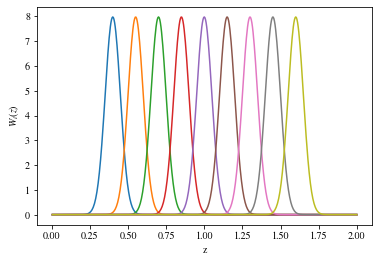

In [22]:
# Plot window functions
for i in range(nbins_G):
    plt.plot(z_arr,kernels_G[i,:])
plt.xlabel('z') ; plt.ylabel('$W_i(z)$')
plt.show()

### Case of auto-spectra only

In [23]:
t0 = time.process_time()
Sijw_G = PySSC.Sij(z_arr,kernels_G)
t1 = time.process_time()
print(t1-t0)

1.6915060850000003


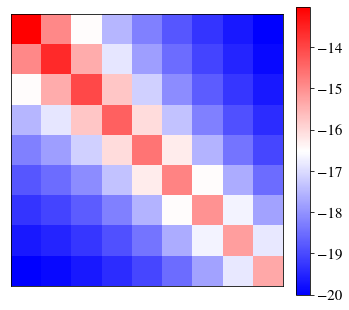

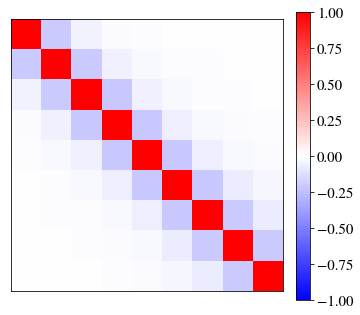

-0.20607289216029379


In [24]:
#First plot ln|Sij|
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(np.log(abs(Sijw_G)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
#Second plot the correlation matrix
correl_G = np.zeros((nbins_G,nbins_G))
for i in range(nbins_G):
    for j in range(nbins_G):
        correl_G[i,j] = Sijw_G[i,j] / np.sqrt(Sijw_G[i,i]*Sijw_G[j,j])
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(correl_G,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
print(correl_G[0,1])

Even though the bins overlap, there is still a significant (20%) anticorrelation between neighbouring bins

### General case with cross-spectra

#### Sijkl method : old way

In [25]:
t0 = time.process_time()
Sijkl_G = PySSC.Sijkl(z_arr,kernels_G)
t1 = time.process_time()
print(t1-t0)

2.755850334999998


In [26]:
#Build indexing of pairs of redshift bins
npairs_G = (nbins_G*(nbins_G+1))//2
pairs_G  = np.zeros((2,npairs_G),dtype=int)
count    = 0
for ibin in range(nbins_G):
    for jbin in range(ibin,nbins_G):
        pairs_G[0,count] = ibin
        pairs_G[1,count] = jbin
        count +=1
#Recast Sijkl as a matrix of pairs, for later visualisation
Sijkl_G_recast = np.zeros((npairs_G,npairs_G))
for ipair in range(npairs_G):
    ibin = pairs_G[0,ipair]
    jbin = pairs_G[1,ipair]
    for jpair in range(npairs_G):
        kbin = pairs_G[0,jpair]
        lbin = pairs_G[1,jpair]
        Sijkl_G_recast[ipair,jpair] = Sijkl_G[ibin,jbin,kbin,lbin]

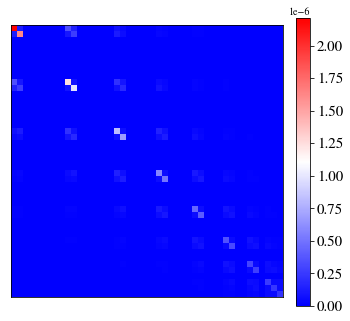

In [27]:
#Plot |Sijkl|
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(abs(Sijkl_G_recast),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()

Many elements are zero : indeed bins far enough apart have basically no overlap so the cross-spectra is zero
<br>If the overlap is small enough (&lt;0.1% by default), the code sets Sijkl to zero

In [28]:
#Remove pairs of bins with zero covariance
invalid_list         = np.where(np.diag(Sijkl_G_recast)==0)[0]
Sijkl_G_recast_valid = np.delete(np.delete(Sijkl_G_recast,invalid_list,0),invalid_list,1)
nvalid               = Sijkl_G_recast_valid.shape[0]

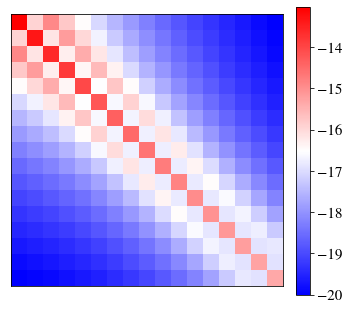

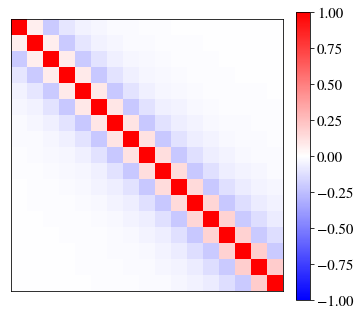

-0.2144958369865919


In [29]:
#Plot ln|Sijkl|
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(np.log(abs(Sijkl_G_recast_valid)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
P.axes.tick_params(labelsize=15)
plt.xticks([]) ; plt.yticks([])
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
#Second plot the correlation matrix
correl_ijkl_G = np.zeros((nvalid,nvalid))
for i in range(nvalid):
    for j in range(nvalid):
        correl_ijkl_G[i,j] = Sijkl_G_recast_valid[i,j] / np.sqrt(Sijkl_G_recast_valid[i,i]*Sijkl_G_recast_valid[j,j])
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(correl_ijkl_G,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
print(correl_ijkl_G.min())

The off-diagonal structure is quite important, there is positive correlation between closest cross-spectra, but also non-negligible anti-correlation with the second-closest cross-spectrum.

#### Sij method : new preferred way

In [30]:
#Build products of two kernels for all pairs of redshift bins
kernel_pairs_G = np.zeros((npairs_G,nz))
for ipair in range(npairs_G):
    ibin = pairs_G[0,ipair]
    jbin = pairs_G[1,ipair]
    kernel_pairs_G[ipair,:] = kernels_G[ibin,:]*kernels_G[jbin,:]

In [34]:
#Compute Sij of pairs
t0 = time.process_time()
Sij_pairs_G = PySSC.Sij(z_arr,kernel_pairs_G,order=1)  #<!> order=1 is important here
t1 = time.process_time()
print(t1-t0)

5.136146700999998


In [35]:
#Remove pairs of bins with zero covariance
Sij_pairs_G_valid = np.delete(np.delete(Sij_pairs_G,invalid_list,0),invalid_list,1)

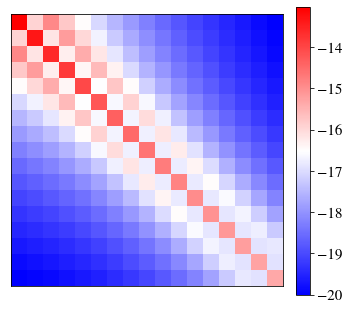

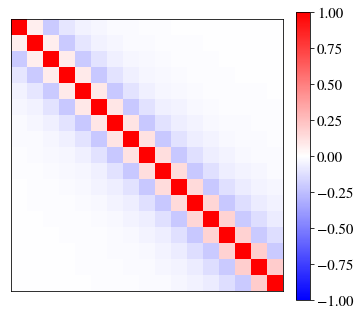

-0.21449583698659183


In [36]:
#Plot ln|Sij|
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(np.log(abs(Sij_pairs_G_valid)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
P.axes.tick_params(labelsize=15)
plt.xticks([]) ; plt.yticks([])
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
#Second plot the correlation matrix
correl_ij_pairs_G = np.zeros((nvalid,nvalid))
for i in range(nvalid):
    for j in range(nvalid):
        correl_ij_pairs_G[i,j] = Sij_pairs_G_valid[i,j] / np.sqrt(Sij_pairs_G_valid[i,i]*Sij_pairs_G_valid[j,j])
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(correl_ij_pairs_G,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
print(correl_ij_pairs_G.min())

In [37]:
#Compare with Sijkl result
diffrel = (Sij_pairs_G_valid-Sijkl_G_recast_valid)/Sij_pairs_G_valid
print(diffrel.min(),diffrel.max())

-5.2928347745977255e-15 6.0916328209435915e-15


The relative difference is at the machine precision